In [ ]:
# @title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License

# Update ML models in running pipelines

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/apache/beam/blob/master/examples/notebooks/beam-ml/automatic_model_refresh.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/colab_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/apache/beam/blob/master/examples/notebooks/beam-ml/automatic_model_refresh.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/github_32px.png" />View source on GitHub</a>
  </td>
</table>


This notebook demonstrates how to perform automatic model updates without stopping your Apache Beam pipeline.
You can use side inputs to update your model in real time, even while the Apache Beam pipeline is running. The side input is passed in a `ModelHandler` configuration object. You can update the model either by leveraging one of Apache Beam's provided patterns, such as the `WatchFilePattern`, or by configuring a custom side input `PCollection` that defines the logic for the model update.

The pipeline in this notebook uses a RunInference `PTransform` with TensorFlow machine learning (ML) models to run inference on images. To update the model, it uses a side input `PCollection` that emits `ModelMetadata`.
For more information about side inputs, see the [Side inputs](https://beam.apache.org/documentation/programming-guide/#side-inputs) section in the Apache Beam Programming Guide.

This example uses `WatchFilePattern` as a side input. `WatchFilePattern` is used to watch for file updates that match the `file_pattern` based on timestamps. It emits the latest `ModelMetadata`, which is used in the RunInference `PTransform` to automatically update the ML model without stopping the Apache Beam pipeline.


## Before you begin
Install the dependencies required to run this notebook.

To use RunInference with side inputs for automatic model updates, use Apache Beam version 2.46.0 or later.

In [ ]:
!pip install apache_beam[gcp]>=2.46.0 --quiet
!pip install tensorflow==2.15.0 --quiet
!pip install tensorflow_hub --quiet

In [ ]:
# Imports required for the notebook.
import logging
import time
from typing import Iterable
from typing import Tuple

import apache_beam as beam
from apache_beam.ml.inference.base import PredictionResult
from apache_beam.ml.inference.base import RunInference
from apache_beam.ml.inference.tensorflow_inference import TFModelHandlerTensor
from apache_beam.ml.inference.utils import WatchFilePattern
from apache_beam.options.pipeline_options import GoogleCloudOptions
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import SetupOptions
from apache_beam.options.pipeline_options import StandardOptions
from apache_beam.options.pipeline_options import WorkerOptions
from apache_beam.transforms.periodicsequence import PeriodicImpulse
import numpy
from PIL import Image
import tensorflow as tf

In [ ]:
# Authenticate to your Google Cloud account.
def auth_to_colab():
  from google.colab import auth
  auth.authenticate_user()

auth_to_colab()

## Configure the runner

This pipeline uses the Dataflow Runner. To run the pipeline, you need to complete the following tasks:

* Ensure that you have all the required permissions to run the pipeline on Dataflow.
* Configure the pipeline options for the pipeline to run on Dataflow. Make sure the pipeline is using streaming mode.

In the following code, replace `BUCKET_NAME` with the the name of your Cloud Storage bucket.

In [ ]:
options = PipelineOptions()
options.view_as(StandardOptions).streaming = True

BUCKET_NAME = '<BUCKET_NAME>' # Replace with your bucket name.

# Provide required pipeline options for the Dataflow Runner.
options.view_as(StandardOptions).runner = "DataflowRunner"

# Set the project to the default project in your current Google Cloud environment.
options.view_as(GoogleCloudOptions).project = '<PROJECT_NAME>'

# Set the Google Cloud region that you want to run Dataflow in.
options.view_as(GoogleCloudOptions).region = 'us-central1'

# IMPORTANT: Replace BUCKET_NAME with the the name of your Cloud Storage bucket.
dataflow_gcs_location = "gs://%s/dataflow" % BUCKET_NAME

# The Dataflow staging location. This location is used to stage the Dataflow pipeline and the SDK binary.
options.view_as(GoogleCloudOptions).staging_location = '%s/staging' % dataflow_gcs_location


# The Dataflow staging location. This location is used to stage the Dataflow pipeline and the SDK binary.
options.view_as(GoogleCloudOptions).staging_location = '%s/staging' % dataflow_gcs_location

# The Dataflow temp location. This location is used to store temporary files or intermediate results before outputting to the sink.
options.view_as(GoogleCloudOptions).temp_location = '%s/temp' % dataflow_gcs_location

options.view_as(SetupOptions).save_main_session = True

# Launching Dataflow with only one worker might result in processing delays due to
# initial input processing. This could further postpone the side input model updates.
# To expedite the model update process, it's recommended to set num_workers>1.
# https://github.com/apache/beam/issues/28776
options.view_as(WorkerOptions).num_workers = 5

Install the `tensorflow` and `tensorflow_hub` dependencies on Dataflow. Use the `requirements_file` pipeline option to pass these dependencies.

In [ ]:
# In a requirements file, define the dependencies required for the pipeline.
!printf 'tensorflow==2.15.0\ntensorflow_hub>=0.10.0\nPillow>=9.0.0' > ./requirements.txt
# Install the pipeline dependencies on Dataflow.
options.view_as(SetupOptions).requirements_file = './requirements.txt'

## Use the TensorFlow model handler
 This example uses `TFModelHandlerTensor` as the model handler and the `resnet_101` model trained on [ImageNet](https://www.image-net.org/).


For the Dataflow runner, you need to store the model in a remote location that the Apache Beam pipeline can access. For this example, download the `ResNet101` model, and upload it to the Google Cloud Storage bucket.


In [ ]:
model = tf.keras.applications.resnet.ResNet101()
model.save('resnet101_weights_tf_dim_ordering_tf_kernels.keras')
# After saving the model locally, upload the model to GCS bucket and provide that gcs bucket `URI` as `model_uri` to the `TFModelHandler`
# Replace `BUCKET_NAME` value with actual bucket name.
!gsutil cp resnet101_weights_tf_dim_ordering_tf_kernels.keras gs://<BUCKET_NAME>/dataflow/resnet101_weights_tf_dim_ordering_tf_kernels.keras

In [ ]:
model_handler = TFModelHandlerTensor(
    model_uri=dataflow_gcs_location + "/resnet101_weights_tf_dim_ordering_tf_kernels.keras")

## Preprocess images

Use `preprocess_image` to run the inference, read the image, and convert the image to a TensorFlow tensor.

In [ ]:
def preprocess_image(image_name, image_dir):
  img = tf.keras.utils.get_file(image_name, image_dir + image_name)
  img = Image.open(img).resize((224, 224))
  img = numpy.array(img) / 255.0
  img_tensor = tf.cast(tf.convert_to_tensor(img[...]), dtype=tf.float32)
  return img_tensor

In [ ]:
class PostProcessor(beam.DoFn):
  """Process the PredictionResult to get the predicted label.
  Returns predicted label.
  """
  def process(self, element: PredictionResult) -> Iterable[Tuple[str, str]]:
    predicted_class = numpy.argmax(element.inference, axis=-1)
    labels_path = tf.keras.utils.get_file(
        'ImageNetLabels.txt',
        'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'  # pylint: disable=line-too-long
    )
    imagenet_labels = numpy.array(open(labels_path).read().splitlines())
    predicted_class_name = imagenet_labels[predicted_class]
    yield predicted_class_name.title(), element.model_id

In [ ]:
# Define the pipeline object.
pipeline = beam.Pipeline(options=options)

Next, review the pipeline steps and examine the code.

### Pipeline steps


1. Create a `PeriodicImpulse` transform, which emits output every `n` seconds. The `PeriodicImpulse` transform generates an infinite sequence of elements with a given runtime interval.

   In this example, `PeriodicImpulse` mimics the Pub/Sub source. Because the inputs in a streaming pipeline arrive in intervals, use `PeriodicImpulse` to output elements at `m` intervals.
To learn more about `PeriodicImpulse`, see the [`PeriodicImpulse` code](https://github.com/apache/beam/blob/9c52e0594d6f0e59cd17ee005acfb41da508e0d5/sdks/python/apache_beam/transforms/periodicsequence.py#L150).

In [ ]:
start_timestamp = time.time() # start timestamp of the periodic impulse
end_timestamp = start_timestamp + 60 * 20 # end timestamp of the periodic impulse (will run for 20 minutes).
main_input_fire_interval = 60 # interval in seconds at which the main input PCollection is emitted.
side_input_fire_interval = 60 # interval in seconds at which the side input PCollection is emitted.

periodic_impulse = (
      pipeline
      | "MainInputPcoll" >> PeriodicImpulse(
          start_timestamp=start_timestamp,
          stop_timestamp=end_timestamp,
          fire_interval=main_input_fire_interval))

2. To read and preprocess the images, use the `preprocess_image` function. This example uses `Cat-with-beanie.jpg` for all inferences.

  **Note**: The image used for prediction is licensed in CC-BY. The creator is listed in the [LICENSE.txt](https://storage.googleapis.com/apache-beam-samples/image_captioning/LICENSE.txt) file.

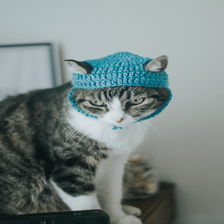

In [ ]:
image_data = (periodic_impulse | beam.Map(lambda x: "Cat-with-beanie.jpg")
      | "ReadImage" >> beam.Map(lambda image_name: preprocess_image(
          image_name=image_name, image_dir='https://storage.googleapis.com/apache-beam-samples/image_captioning/')))

3. Pass the images to the RunInference `PTransform`. RunInference takes `model_handler` and `model_metadata_pcoll` as input parameters.
  * `model_metadata_pcoll` is a side input `PCollection` to the RunInference `PTransform`. This side input updates the `model_uri` in the `model_handler` while the Apache Beam pipeline runs.
  * Use `WatchFilePattern` as side input to watch a `file_pattern` matching `.keras` files. In this case, the `file_pattern` is `'gs://BUCKET_NAME/dataflow/*keras'`.



In [ ]:
 # The side input used to watch for the .keras file and update the model_uri of the TFModelHandlerTensor.
file_pattern = dataflow_gcs_location + '/*.keras'
side_input_pcoll = (
      pipeline
      | "WatchFilePattern" >> WatchFilePattern(file_pattern=file_pattern,
                                                interval=side_input_fire_interval,
                                                stop_timestamp=end_timestamp))
inferences = (
      image_data
      | "ApplyWindowing" >> beam.WindowInto(beam.window.FixedWindows(10))
      | "RunInference" >> RunInference(model_handler=model_handler,
                                      model_metadata_pcoll=side_input_pcoll))

4. Post-process the `PredictionResult` object.
When the inference is complete, RunInference outputs a `PredictionResult` object that contains the fields `example`, `inference`, and `model_id`. The `model_id` field identifies the model used to run the inference. The `PostProcessor` returns the predicted label and the model ID used to run the inference on the predicted label.

In [ ]:
post_processor = (
    inferences
    | "PostProcessResults" >> beam.ParDo(PostProcessor())
    | "LogResults" >> beam.Map(logging.info))

### Watch for the model update

After the pipeline starts processing data, when you see output emitted from the RunInference `PTransform`, upload a `resnet152` model saved in the `.keras` format to a Google Cloud Storage bucket location that matches the `file_pattern` you defined earlier.


In [ ]:
model = tf.keras.applications.resnet.ResNet152()
model.save('resnet152_weights_tf_dim_ordering_tf_kernels.keras')
# Replace the `BUCKET_NAME` with the actual bucket name.
!gsutil cp resnet152_weights_tf_dim_ordering_tf_kernels.keras gs://<BUCKET_NAME>/resnet152_weights_tf_dim_ordering_tf_kernels.keras

## Run the pipeline

Use the following code to run the pipeline.

In [ ]:
# Run the pipeline.
result = pipeline.run().wait_until_finish()